<a href="https://colab.research.google.com/github/luiszac/crop-prediction/blob/main/PREVISION_DE_CULTIVOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Aplicación de técnicas de previsión de series temporales basadas en aprendizaje de máquina para el pronóstico de la producción de principales cultivos de la Región La Libertad##

#IMPORTANDO LIBRERIAS#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#IMPORTANDO CONJUNTO DE DATOS#

In [ ]:
# Cargar y preparar los datos de la serie temporal multivariada
# Supongamos que tienes un archivo CSV con tus datos multivariados
datos = pd.read_csv('cultivos.csv')
datos

,Periodo,Esparrago,Maiz amarillo duro,Palta,Uva,Temperatura,Precipitacion,Humedad,IS_esparrago,IS_Maiz amarillo duro,IS_palta,IS_Uva
0,1/01/2001,8674.0,6604.0,699.00,3757.0,21.50,0.40,75.40,8529.0,5486.0,1688.0,1917.0
1,1/02/2001,7448.4,7475.0,792.00,3969.0,23.80,1.30,76.10,8319.0,8848.0,1688.0,1917.0
2,1/03/2001,7564.5,8018.0,1702.00,3999.0,23.50,1.30,76.00,7889.0,11662.5,1688.0,1917.0
3,1/04/2001,7023.0,3718.0,1371.00,4185.0,21.40,0.87,74.30,7727.0,14171.5,1688.0,1932.0
4,1/05/2001,5683.0,7883.0,1507.00,3476.0,18.10,0.20,73.70,7462.0,15580.0,1688.0,1932.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,1/08/2020,10295.9,26915.2,6123.55,2857.5,18.73,0.99,82.00,14643.0,4459.0,15569.0,3938.0
236,1/09/2020,9432.1,8130.0,10090.58,4197.8,18.92,0.59,80.80,14659.0,4621.0,15577.0,3578.0
237,1/10/2020,9913.0,5443.0,5008.40,5183.1,19.35,0.38,77.59,14546.0,4434.0,15985.0,3800.0
238,1/11/2020,13612.3,9447.5,4320.20,6995.5,21.00,0.88,77.51,14524.0,4547.0,15523.0,3700.0


In [ ]:
datos.Periodo=pd.to_datetime(datos.Periodo,dayfirst=True)
datos.Periodo

0     2001-01-01
1     2001-02-01
2     2001-03-01
3     2001-04-01
4     2001-05-01
         ...    
235   2020-08-01
236   2020-09-01
237   2020-10-01
238   2020-11-01
239   2020-12-01
Name: Periodo, Length: 240, dtype: datetime64[ns]

In [ ]:
datos.set_index("Periodo",inplace=True)
datos.head()

,Esparrago,Maiz amarillo duro,Palta,Uva,Temperatura,Precipitacion,Humedad,IS_esparrago,IS_Maiz amarillo duro,IS_palta,IS_Uva
Periodo,,,,,,,,,,,
2001-01-01,8674.0,6604.0,699.0,3757.0,21.5,0.40,75.4,8529.0,5486.0,1688.0,1917.0
2001-02-01,7448.4,7475.0,792.0,3969.0,23.8,1.30,76.1,8319.0,8848.0,1688.0,1917.0
2001-03-01,7564.5,8018.0,1702.0,3999.0,23.5,1.30,76.0,7889.0,11662.5,1688.0,1917.0
2001-04-01,7023.0,3718.0,1371.0,4185.0,21.4,0.87,74.3,7727.0,14171.5,1688.0,1932.0
2001-05-01,5683.0,7883.0,1507.0,3476.0,18.1,0.20,73.7,7462.0,15580.0,1688.0,1932.0


#VISUALIZANDO LAS SERIES TEMPORALES#

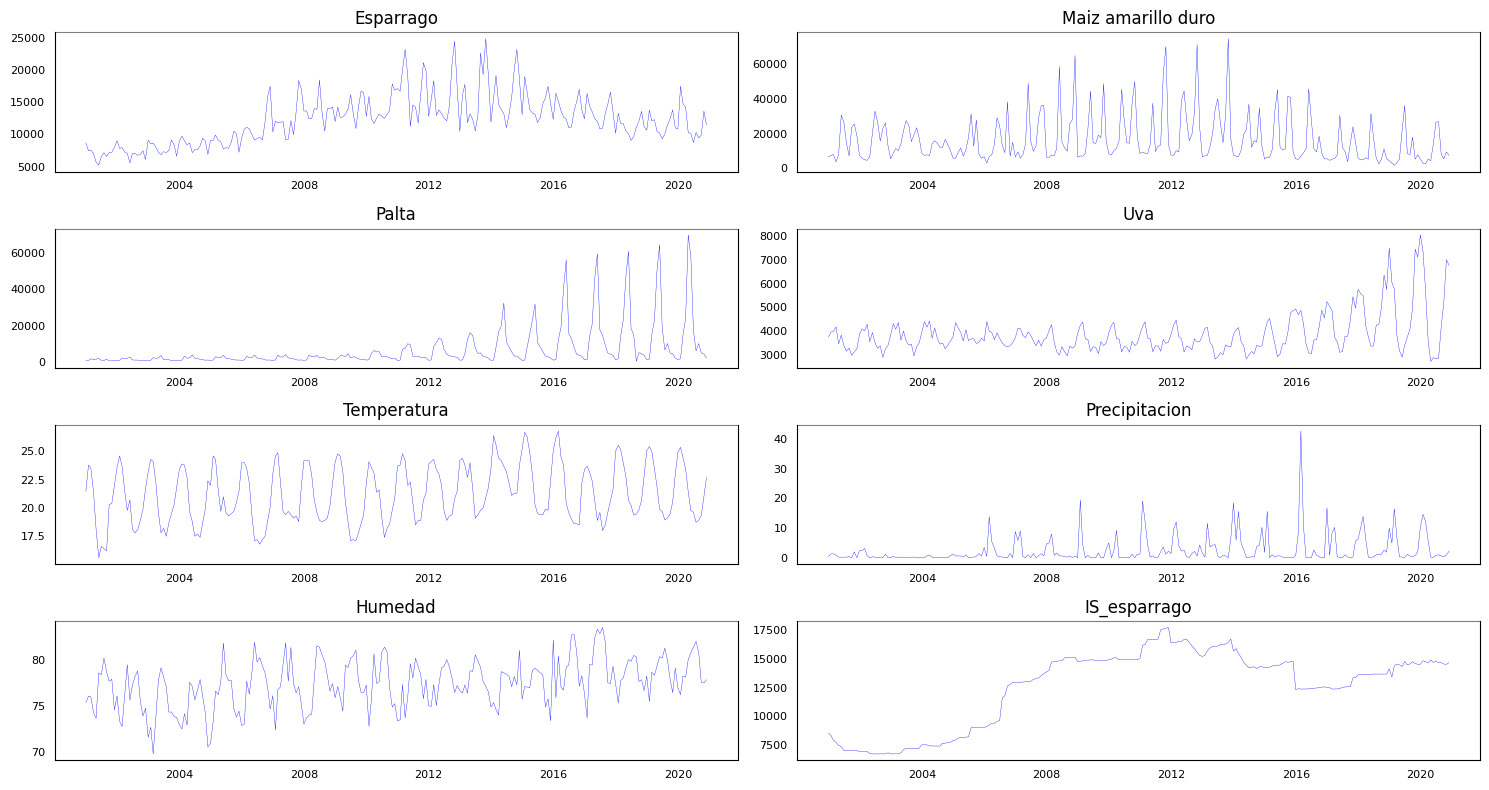

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=100, figsize=(15,8))
for i, ax in enumerate(axes.flatten()):
    data = datos[datos.columns[i]]
    ax.plot(data, color='blue', linewidth=0.25)
    # Decorations
    ax.set_title(datos.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0.5)
    ax.tick_params(labelsize=8)

plt.tight_layout();

#Testing Causation using Granger’s Causality Test#

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    datos = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in datos.columns:
        for r in datos.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            datos.loc[r, c] = min_p_value
    datos.columns = [var + '_x' for var in variables]
    datos.index = [var + '_y' for var in variables]
    return datos

grangers_causation_matrix(datos, variables = datos.columns)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

,Esparrago_x,Maiz amarillo duro_x,Palta_x,Uva_x,Temperatura_x,Precipitacion_x,Humedad_x,IS_esparrago_x,IS_Maiz amarillo duro_x,IS_palta_x,IS_Uva_x
Esparrago_y,1.0000,0.0000,0.0000,0.0003,0.0000,0.0000,0.0010,0.0000,0.0000,0.0006,0.0006
Maiz amarillo duro_y,0.0000,1.0000,0.0009,0.0000,0.0000,0.0000,0.0000,0.0019,0.0000,0.0091,0.0023
Palta_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Uva_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0302,0.0000,0.0000,0.0000
Temperatura_y,0.0000,0.0000,0.0000,0.0001,1.0000,0.0245,0.0001,0.0007,0.0000,0.0000,0.0018
Precipitacion_y,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0311
Humedad_y,0.0052,0.0000,0.0000,0.0001,0.0000,0.0000,1.0000,0.0018,0.0000,0.0001,0.0007
IS_esparrago_y,0.0232,0.0014,0.8546,0.0814,0.2894,0.1857,0.0789,1.0000,0.0533,0.1411,0.1764
IS_Maiz amarillo duro_y,0.0001,0.0000,0.0002,0.0000,0.0000,0.0010,0.0000,0.0100,1.0000,0.0021,0.0000
IS_palta_y,0.0000,0.0007,0.3013,0.1090,0.7871,0.5180,0.4010,0.0000,0.0684,1.0000,0.0001


#Prueba de cointegración#

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(datos, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(datos,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  n', '--'*20)
    for col, trace, cvt in zip(datos.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(datos)

Name   ::  Test Stat > C(95%)    =>   Signif  n ----------------------------------------
Esparrago ::  561.6     > 263.2603  =>   True
Maiz amarillo duro ::  410.05    > 219.4051  =>   True
Palta  ::  306.25    > 179.5199  =>   True
Uva    ::  230.25    > 143.6691  =>   True
Temperatura ::  168.53    > 111.7797  =>   True
Precipitacion ::  121.2     > 83.9383   =>   True
Humedad ::  79.21     > 60.0627   =>   True
IS_esparrago ::  40.07     > 40.1749   =>   False
IS_Maiz amarillo duro ::  17.33     > 24.2761   =>   False
IS_palta ::  6.42      > 12.3212   =>   False
IS_Uva ::  0.07      > 4.1296    =>   False


#Dividir la serie en datos de prueba y entrenamiento#

In [ ]:
nobs = 24
df_train, df_test = datos[0:-nobs], datos[-nobs:]

# Check size
print(df_train.shape)  # (216, 11)
print(df_test.shape)  # (24, 11)

(216, 11)
(24, 11)


#Verificar la estacionariedad y establezca la serie de tiempo estacionaria#

#Prueba Dickey-Fuller aumentada (prueba ADF)#

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('n')

<ipython-input-42-16ed3d3daf4b>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_train.iteritems():


    Augmented Dickey-Fuller Test on "Esparrago" n    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6212
 No. Lags Chosen       = 12
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.4721. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
n
    Augmented Dickey-Fuller Test on "Maiz amarillo duro" n    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.8778
 No. Lags Chosen       = 11
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.7952. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
n
    Augmented Dickey-Fuller Test on "Palta" n    -----------------------------------------------
 Null Hypoth

#Diferenciacion#

In [ ]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [ ]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('n')

<ipython-input-44-cd511d260222>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_differenced.iteritems():


    Augmented Dickey-Fuller Test on "Esparrago" n    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3463
 No. Lags Chosen       = 11
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
n
    Augmented Dickey-Fuller Test on "Maiz amarillo duro" n    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.7215
 No. Lags Chosen       = 10
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
n
    Augmented Dickey-Fuller Test on "Palta" n    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signif

#segunda diferenciacion#

In [ ]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('n')

<ipython-input-46-1e6ab1e0c68f>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_differenced.iteritems():


    Augmented Dickey-Fuller Test on "Esparrago" n    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4131
 No. Lags Chosen       = 15
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
n
    Augmented Dickey-Fuller Test on "Maiz amarillo duro" n    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2538
 No. Lags Chosen       = 15
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
n
    Augmented Dickey-Fuller Test on "Palta" n    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signif

#Ahora todas las series son estacionarias#

#seleccionar el pedido (P) del modelo VAR#

In [ ]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, 'n')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  117.90698785549758
BIC :  119.99004215537384
FPE :  1.6103667187518795e+51
HQIC:  118.74881943171478 n
Lag Order = 2
AIC :  116.1826794294583
BIC :  120.18841682328858
FPE :  2.8946257175762358e+50
HQIC:  117.80170491466241 n
Lag Order = 3
AIC :  115.61957368947728
BIC :  121.56078194502254
FPE :  1.6845333819121806e+50
HQIC:  118.02112806780366 n
Lag Order = 4
AIC :  114.92589299794321
BIC :  122.81550360606296
FPE :  8.788433753545126e+49
HQIC:  118.1153701816499 n
Lag Order = 5
AIC :  114.0074975278898
BIC :  123.85858795473345
FPE :  3.774628924063046e+49
HQIC:  117.99035123995364 n
Lag Order = 6
AIC :  113.15351204348943
BIC :  124.97930802781573
FPE :  1.801153522380599e+49
HQIC:  117.93525671663345 n
Lag Order = 7
AIC :  112.58397889021697
BIC :  126.3978567869401
FPE :  1.2055052769463195e+49
HQIC:  118.17019058272663 n
Lag Order = 8
AIC :  112.21359379373334
BIC :  128.02908296482556
FPE :  1.0564196530416056e+49
HQIC:  118.60991112242836 n
Lag Order = 9
A

In [ ]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,121.5,121.7,5.856e+52,121.6
1,118.2,120.4*,2.194e+51,119.1
2,116.5,120.6,3.924e+50,118.2
3,115.9,122.0,2.261e+50,118.4
4,115.2,123.3,1.125e+50,118.4
5,114.2,124.3,4.825e+49,118.3
6,113.3,125.4,2.165e+49,118.2
7,112.6,126.7,1.313e+49,118.3
8,112.3,128.3,1.176e+49,118.8
9,111.2,129.2,5.612e+48,118.5


#Entrenar el modelo con el orden p#

In [ ]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Sep, 2023
Time:                     16:14:54
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    129.263
Nobs:                     202.000    HQIC:                   114.997
Log likelihood:          -12325.4    FPE:                9.76142e+46
AIC:                      105.302    Det(Omega_mle):     3.74012e+44
--------------------------------------------------------------------
Results for equation Esparrago
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                           -12.322751       120.289739           -0.102           0.918
L1.Esparrago                     -1.209241         0.117943          -10.253           0.000
L1.Maiz 

#Comprobando la correlación en serie de los residuos (errores) mediante la estadística de Durbin Watson#

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(datos.columns, out):
    print(adjust(col), ':', round(val, 2))

NameError: ignored

#pronosticar el Modelo VAR"

In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

12


array([[-4.380600e+02, -7.042000e+02, -1.747320e+03,  1.251310e+03,
         2.430000e+00, -4.650000e+00, -3.780000e+00,  2.595000e+02,
         1.357000e+03,  7.267000e+02,  2.390000e+01],
       [ 6.472600e+03,  8.377350e+03,  2.967090e+03, -9.690100e+02,
        -2.910000e+00,  3.050000e+00, -1.600000e-01, -2.635000e+02,
         2.175500e+03, -7.509000e+02, -2.190000e+01],
       [-4.629200e+03,  1.079150e+03,  1.188863e+04,  1.147600e+02,
        -8.900000e-01, -5.000000e-02,  4.480000e+00,  2.940000e+01,
        -1.892500e+03,  3.000000e+00, -2.000000e+00],
       [ 1.518300e+03,  1.044600e+03, -3.299520e+03, -1.200730e+03,
        -8.100000e-01, -1.155000e+01, -2.140000e+00, -2.240000e+01,
        -8.610000e+02,  8.000000e+00,  0.000000e+00],
       [-1.072300e+03, -1.929200e+03,  1.467009e+04,  8.204000e+02,
        -2.000000e-02,  1.850000e+00,  8.200000e-01, -6.000000e+00,
         2.485000e+02, -9.000000e+00,  0.000000e+00],
       [ 6.624000e+02,  2.700210e+04, -9.640380e+0

In [ ]:
#Forecast
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=datos.index[-nobs:], columns=datos.columns + '_2d')
df_forecast

,Esparrago_2d,Maiz amarillo duro_2d,Palta_2d,Uva_2d,Temperatura_2d,Precipitacion_2d,Humedad_2d,IS_esparrago_2d,IS_Maiz amarillo duro_2d,IS_palta_2d,IS_Uva_2d
Periodo,,,,,,,,,,,
2019-01-01,-1499.172861,8474.477558,-3418.348272,1709.253565,-0.008470,20.430612,8.573823,-492.915997,-2376.047896,100.324094,40.174565
2019-02-01,9610.607232,-3489.087637,10601.913851,-1663.731846,0.269557,-29.076813,-18.032353,793.501613,5040.706367,121.843490,-23.064428
2019-03-01,-7562.724748,-2967.357707,3567.622870,628.441773,-3.128295,19.225521,16.425156,-561.038608,-2542.445771,-175.760182,-22.245198
2019-04-01,-8.693956,-1070.319263,3657.621366,-1823.400077,-1.380846,-24.436254,-7.213204,404.886601,64.522843,126.702320,0.823420
2019-05-01,38.352164,2564.430511,11177.967183,1487.614292,-0.535437,12.819442,6.570803,256.426911,518.090183,-125.305933,23.170485
2019-06-01,1968.718558,29065.857346,-10340.625812,-281.086887,1.021697,3.739357,-7.305657,-195.748860,-2781.285649,-12.400172,-73.569571
2019-07-01,-1186.417631,-41611.661467,-62942.991926,589.589982,2.772146,-9.597682,0.718232,-195.853121,963.676296,123.741568,79.033265
2019-08-01,1314.158849,14980.440763,46424.420237,928.631496,-2.197812,16.685906,3.629890,183.894419,-1467.133855,43.036353,38.626866
2019-09-01,1731.222005,-9443.254798,-19150.496810,-817.260001,0.792129,-11.053311,-3.797929,-221.285398,3941.321267,-157.728900,-13.951068


In [ ]:
#Invertir la transformacion de diferenciacion para el pronostico real
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

KeyError: ignored

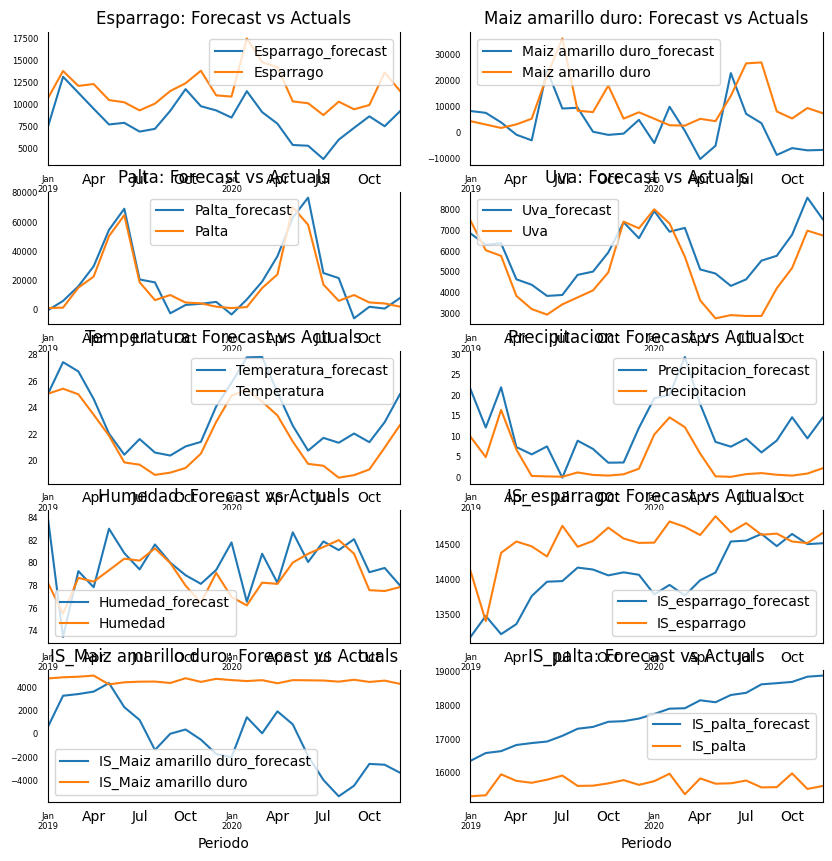

In [ ]:
fig, axes = plt.subplots(nrows=int(len(datos.columns)/2), ncols=2, dpi=100, figsize=(10,10))
for i, (col,ax) in enumerate(zip(datos.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)


# Metricas MAPE, ME, MAE, MPE, RMSE, corr y minmax.

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp


KeyError: ignored

In [ ]:
#Importando librerias para implementar modelos autorregresivos
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Cargar los datos de la serie de tiempo multivariado
data = pd.read_csv('cultivos.csv')
data.head()

,Periodo,Esparrago,Maiz amarillo duro,Palta,Uva,Temperatura,Precipitacion,Humedad,IS_esparrago,IS_Maiz amarillo duro,IS_palta,IS_Uva
0,1/01/2001,8674.0,6604.0,699.0,3757.0,21.5,0.40,75.4,8529.0,5486.0,1688.0,1917.0
1,1/02/2001,7448.4,7475.0,792.0,3969.0,23.8,1.30,76.1,8319.0,8848.0,1688.0,1917.0
2,1/03/2001,7564.5,8018.0,1702.0,3999.0,23.5,1.30,76.0,7889.0,11662.5,1688.0,1917.0
3,1/04/2001,7023.0,3718.0,1371.0,4185.0,21.4,0.87,74.3,7727.0,14171.5,1688.0,1932.0
4,1/05/2001,5683.0,7883.0,1507.0,3476.0,18.1,0.20,73.7,7462.0,15580.0,1688.0,1932.0


In [ ]:
# Especificar las columnas que se utilizarán como variables independientes
variables_independientes = ['Maiz amarillo duro']

In [ ]:
# Estimar automáticamente el orden del mejor modelo ARIMA
modelo_auto = auto_arima(data[variables_independientes], seasonal=False)
modelo_auto

ARIMA(order=(5, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Ajustar el modelo a los datos
modelo_ajustado = ARIMA(data[variables_independientes], order=modelo_auto.order).fit()
modelo_ajustado

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


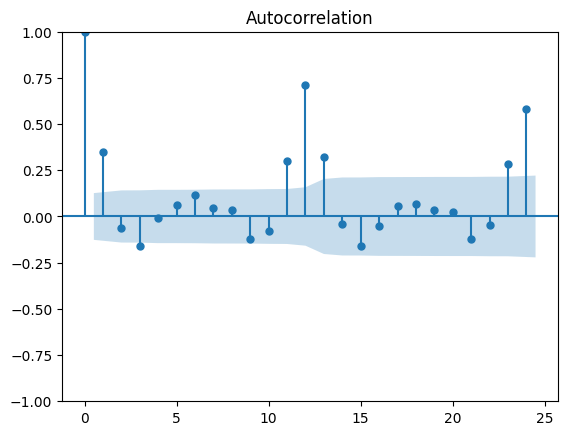

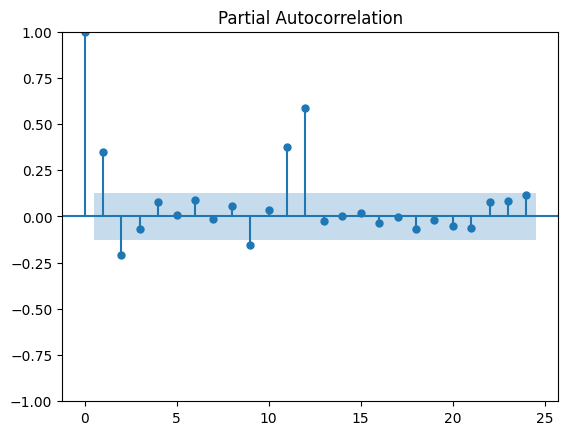

In [ ]:
# Calcular la autocorrelación parcial y total
acf_plot = plot_acf(data[variables_independientes], lags=24)
pacf_plot = plot_pacf(data[variables_independientes], lags=24)
# Mostrar las gráficas
plt.show()

In [ ]:
# Mostrar las gráficas
plt.show()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

# MODELO ARIMA #


In [ ]:
import numpy as np
import pandas as pd
#GRAFICOS
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

In [ ]:
pip install hvplot

In [ ]:
# Modelado y Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from pmdarima import ARIMA

In [ ]:
pip install skforecast

In [ ]:
pip install pmdarima

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("cultivos.csv")[["Periodo","Esparrago"]]
df["Periodo"] = pd.to_datetime(df["Periodo"], format = "%d/%m/%Y")

df = df.set_index("Periodo")

df.head()

,Esparrago
Periodo,
2001-01-01,8674.0
2001-02-01,7448.4
2001-03-01,7564.5
2001-04-01,7023.0
2001-05-01,5683.0


In [ ]:
fin_train = '2015-12-31 23:59:00'
fin_validacion = '2018-12-31 23:59:00'

df_train = df.loc[: fin_train, :]
df_val   = df.loc[fin_train:fin_validacion, :]
df_test  = df.loc[fin_validacion:, :]

print(f"Fechas train      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Fechas validación : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Fechas test       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Fechas train      : 2001-01-01 00:00:00 --- 2015-12-01 00:00:00  (n=180)
Fechas validación : 2016-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=36)
Fechas test       : 2019-01-01 00:00:00 --- 2020-12-01 00:00:00  (n=24)


In [ ]:
pip install hvplot

:Overlay
   .Curve.Train :Curve   [Periodo]   (Esparrago)
   .Curve.Val   :Curve   [Periodo]   (Esparrago)
   .Curve.Test  :Curve   [Periodo]   (Esparrago)

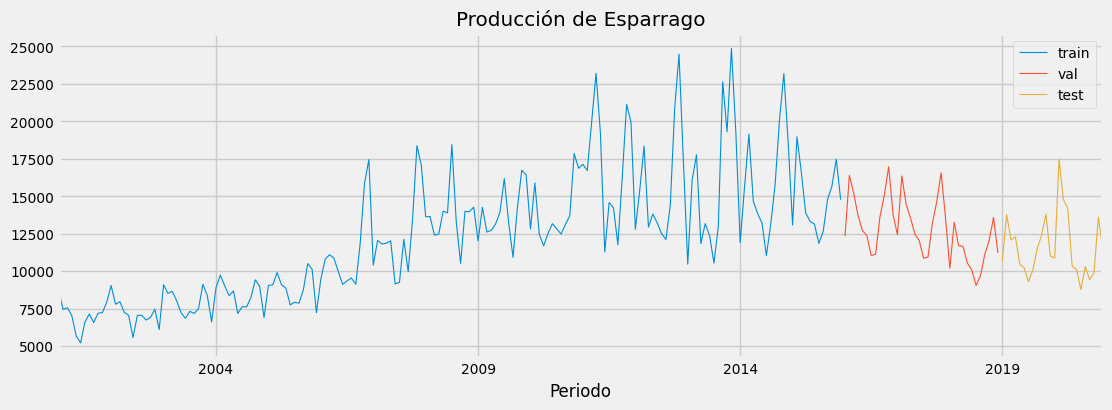

In [ ]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
df_train.Esparrago.plot(ax=ax, label='train', linewidth=0.8)
df_val.Esparrago.plot(ax=ax, label='val', linewidth=0.8)
df_test.Esparrago.plot(ax=ax, label='test', linewidth=0.8)
ax.set_title('Producción de Esparrago')
ax.legend();
# Gráfico serie temporal
plot_train = df_train.Esparrago.hvplot.line(label='train')
plot_val = df_val.Esparrago.hvplot.line(label='val')
plot_test = df_test.Esparrago.hvplot.line(label='test')
layout = plot_train * plot_val * plot_test
layout = layout.opts(title='Produccion de Esparrago', ylabel='Esparrago')
layout = layout.opts(height=300, width=550)
layout

:Overlay
   .BoxWhisker.I      :BoxWhisker   [mes]   (Esparrago)
   .Curve.Esparrago   :Curve   [mes]   (Esparrago)
   .Scatter.Esparrago :Scatter   [mes]   (Esparrago)

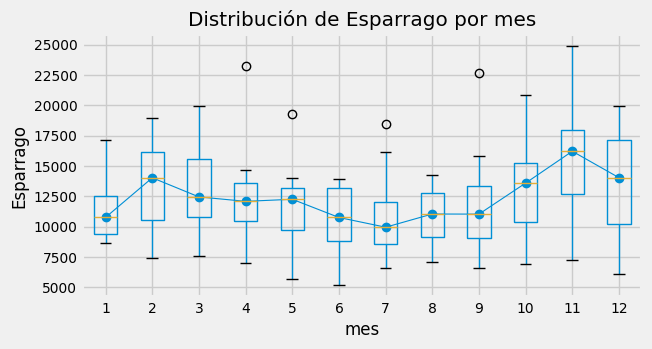

In [ ]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
df['mes'] = df.index.month
df.boxplot(column='Esparrago', by='mes', ax=ax,)
df.groupby('mes')['Esparrago'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Esparrago')
ax.set_title('Distribución de Esparrago por mes')
fig.suptitle('');
df['mes'] = df.index.month
boxplot  = df.sort_values('mes').hvplot.box(
               y                  = 'Esparrago',
               by                 = 'mes',
               legend             = False,
               box_fill_color     = None,
               outlier_fill_color = None
           )
lineplot = df.groupby('mes')['Esparrago'].median().hvplot.line(legend=False)
scatterplot = df.groupby('mes')['Esparrago'].median().hvplot.scatter(legend=False)
layout = boxplot * lineplot * scatterplot
layout = layout.opts(title='Distribución de visitas por mes', ylabel='Esparrago')
layout = layout.opts(height=300, width=500)
layout

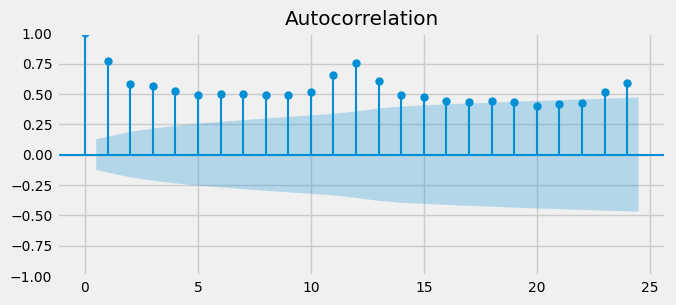

In [ ]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df.Esparrago, ax=ax, lags=24)
plt.show()

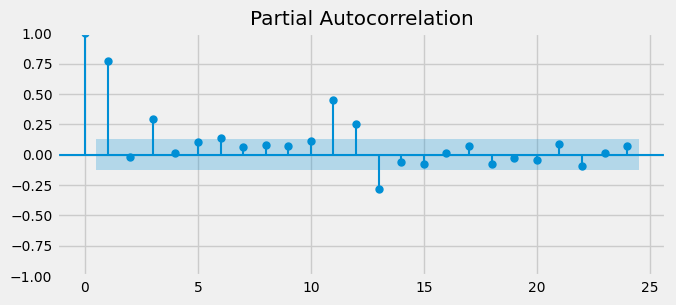

In [ ]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(df.Esparrago, ax=ax, lags=24)
plt.show()

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = StandardScaler(),
                 forecaster_id = 'Produccion de esparrago'
             )

forecaster.fit(y=df_train.Esparrago)
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 179] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-09-19 06:59:13 
Last fit date: 2023-09-19 06:59:13 
Skforecast version: 0.10.0 
Python version: 3.10.12 
Forecaster id: Produccion de esparrago 

In [ ]:
# Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = df.Esparrago,
                            initial_train_size = len(df.loc[:fin_validacion]),
                            steps              = 12,
                            refit              = False,
                            fixed_train_size   = False,
                            metric             = 'mean_absolute_error',
                            verbose            = True,
                            show_progress      = False
                        )

print('Error backtest: {metrica}')
predicciones.head(1)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 216
Number of observations used for backtesting: 24
    Number of folds: 2
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2001-01-01 00:00:00 -- 2018-12-01 00:00:00  (n=216)
    Validation: 2019-01-01 00:00:00 -- 2019-12-01 00:00:00  (n=12)
Fold: 1
    Training:   2001-01-01 00:00:00 -- 2018-12-01 00:00:00  (n=216)
    Validation: 2020-01-01 00:00:00 -- 2020-12-01 00:00:00  (n=12)



KeyError: ignored

In [ ]:
df.index = pd.to_datetime(df.index)

In [ ]:
# ForecasterSarimax
# ==============================================================================
forecaster_sarimax = ForecasterSarimax(
                         regressor     = ARIMA(order=(12, 0, 0), maxiter=250),
                         fit_kwargs    = {'disp': 0},
                         forecaster_id = 'Esparrago'
                     )

# Backtest ARIMA
# ==============================================================================
metrica, predicciones = backtesting_sarimax(
                            forecaster         = forecaster_sarimax,
                            y                  = df.Esparrago,
                            initial_train_size = len(df.loc[:fin_validacion]),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True
                        )

print(f'Error backtest: {metrica}')
predicciones.head(1)

  0%|          | 0/24 [00:00<?, ?it/s]

TypeError: ignored